#**IMPORT LIBRARIES**

In [20]:
import cv2
import pandas as pd
import tqdm
from tqdm import trange
import numpy as np
import os
from google.colab.patches import cv2_imshow
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**CROP IMAGE**

In [14]:
def display_img(cols, rows, **img):
  fig = plt.figure(figsize=(25,14))
  for i in range(cols*rows):
    title = img["title"][i]
    image = img["img"][i].copy()
    fig.add_subplot(rows, cols, i+1)
    plt.title(title, size = 19)
    try:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except:
      image = img["img"][i].copy()
    plt.imshow(image, interpolation= "bicubic")
    plt.axis("off")

In [3]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

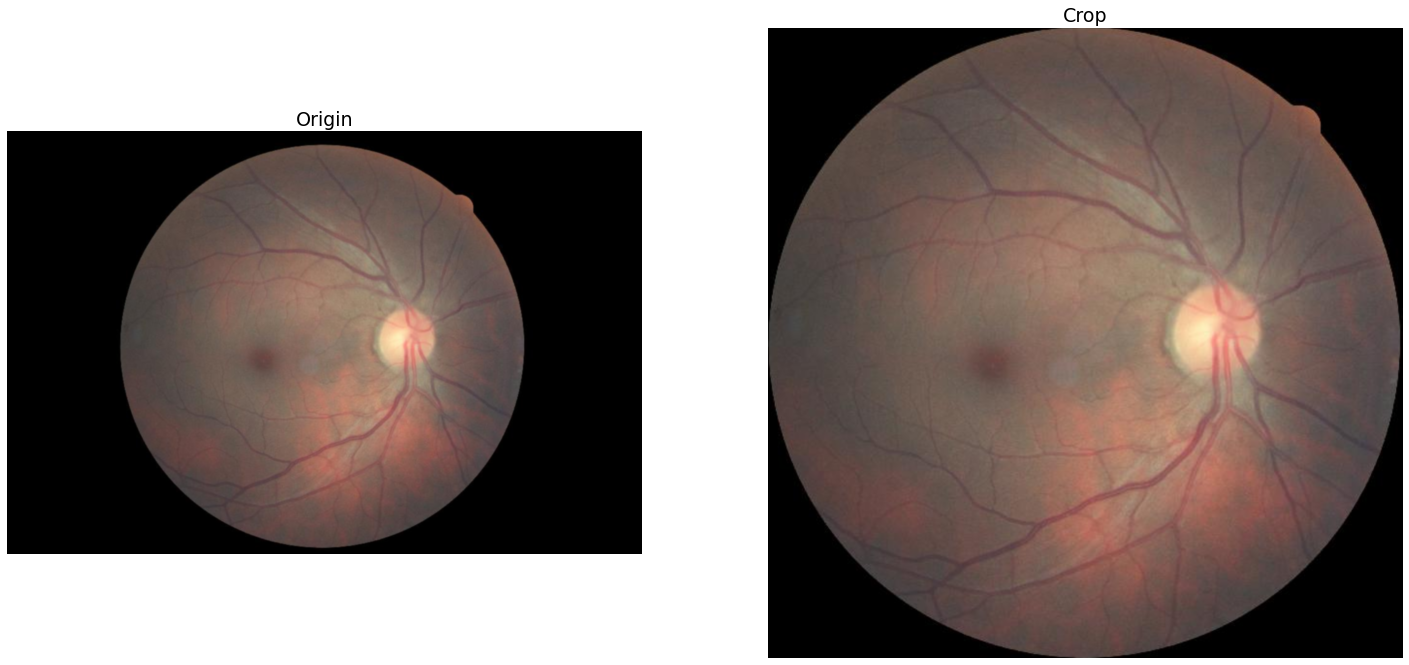

In [15]:
img = cv2.imread("/content/drive/MyDrive/Project_CV_IP/DATA/train/Imbalance/Origin/train/0/44347_right.jpeg")
crop_img = crop_image_from_gray(img)
display_img(2,1 ,img = [img, crop_img], title = ["Origin", "Crop"])

#**CLAHE**

In [4]:
def clahe(img):
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  lab_planes = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=5.0,tileGridSize=(11,11))
  lab_planes[0] = clahe.apply(lab_planes[0])
  lab = cv2.merge(lab_planes)
  bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  bgr = cv2.fastNlMeansDenoisingColored(bgr, h = 3)
  return bgr

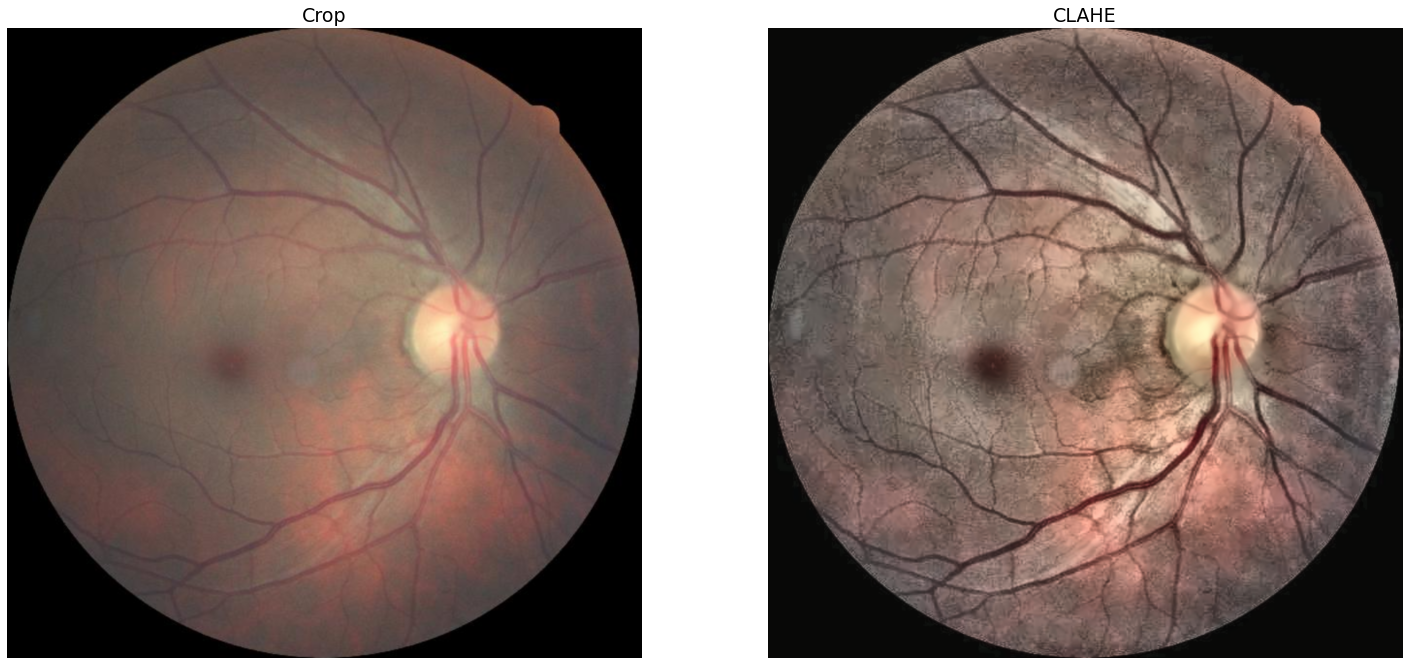

In [17]:
clahe_img = clahe(crop_img)
display_img(2,1 ,img = [crop_img, clahe_img], title = ["Crop", "CLAHE"])

#**CONSTRAST**

In [5]:
def scaleRadius(img , scale):
  x=img[math.floor(img.shape[0]/2)].sum(1)
  r=(x>x.mean()/10).sum()/2
  s=scale*1.0/r
  return cv2.resize(img,(0,0) , fx=s , fy=s)

In [24]:
def Btgraham(img, scale):
    a=scaleRadius(img,scale)
    a=cv2.addWeighted(a, 4, cv2.GaussianBlur(a, (0,0) ,scale/30) , -4 ,128)
    b=np.zeros(a.shape)
    cv2.circle(b ,(math.floor(a.shape[1]/2),math.floor(a.shape[0]/2)) , int(scale*0.9), (1, 1, 1) , -1, 8, 0)
    a=a*b+128*(1-b)
    return a.astype("uint8")

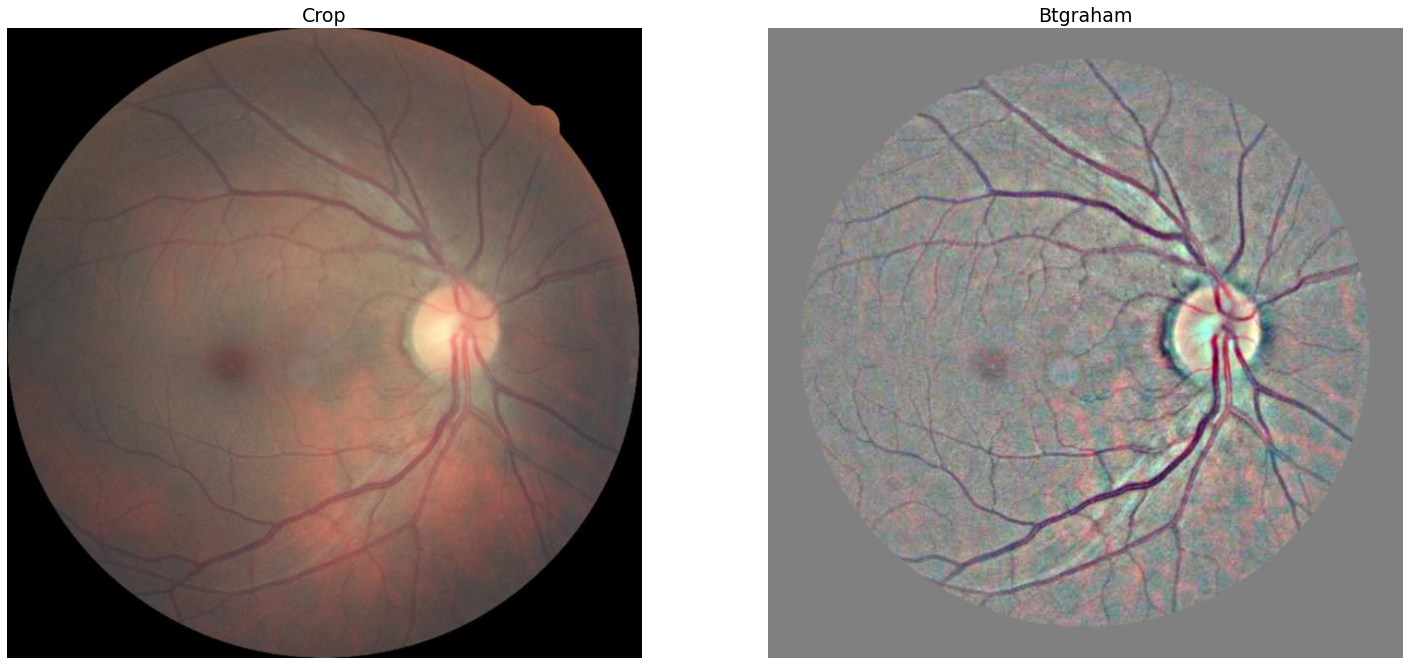

In [25]:
bt_img = Btgraham(crop_img, 300)
display_img(2,1 ,img = [crop_img, bt_img], title = ["Crop", "Btgraham"])